<a href="https://colab.research.google.com/github/Jieoi/traffic_sign_recognition/blob/main/5_model_training_simple_enhanced_data_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: This instance of Google Colab has been configured to use T4 GPU. It is possible to run all other sections at a slower rate on CPU.

Note: The code below has been configured to run on Google colab with python scripts and data imported from google drive. Please download the scripts and data from [here](https://drive.google.com/drive/folders/1nViTcpc952b0ftRGqkDBFqbSEC01t0a8). Files required including all scripts and helper files under data_preparation folder and data_augmentation folder. Alternatively, vist my github repository to [download](https://github.com/Jieoi/traffic_sign_recognition/tree/main) the scripts and helper files.

<h2> 5. Machine Learning on Simple Enhanced Images using CNN</h2>

Based on Notebook 1 [Training data preparation using simple technic](https://github.com/Jieoi/traffic_sign_recognition/blob/main/1_train_data_preparation_simple.ipynb), this notebook is used to train a CNN model on the enhanced training data.

The testing data is also loaded to evaluate the models as they are being developed.

The testing data is from Notebook 3 [Testing data preparation using simple technic](https://github.com/Jieoi/traffic_sign_recognition/blob/main/3_test_data_preparation_simple.ipynb).

There is **no need to run the notebooks named above**, a copy of the prepared data is saved in the Google drive which will be loaded in 5.1.1.

<h2> 5.1 Data Preparation for Machine Learning</h2>

Firstly, the data that were enhanced and augmented were loaded from the Google drive. As this colab instance is configured to use T4 GPU, some configuration checks are conducted to ensure the GPU is available. Libraries that are needed for machine learning were also imported.

<h2>5.1.1 Preparing the notebook</h2>

The first step is to connect to Google Drive so that the data enhanced in the previouse notebook can be used.

The exact files that the notebook needs to  access are <code>image_enhanced_PIL_simple.zip</code> and <code>image_enhanced_simple_data.csv</code>. They can be found in the train_data and test_data folders <a href="https://drive.google.com/drive/folders/1nViTcpc952b0ftRGqkDBFqbSEC01t0a8">here</a>.

Ideally, the notebook should be run in Google Colab with high RAM and GPU support. However, the code can be excuted on CPU only mode with a longer training time.

In [ ]:
# Checking GPU availability
!nvidia-smi

Sat Sep  9 08:43:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The output above shows that the GPU is available.

Google drive is also mounted to the colab instance, allowing access to the data. Relative path is used unless specified.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('drive', force_remount=True)

Mounted at drive


The libraries used in this notebook are listed below.

In [ ]:
# Zip file handling
import zipfile
import os

# Data handling and visualization
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image data handling
from PIL import Image

# File handling and management for training and validation data
from shutil import copyfile
from sklearn.model_selection import train_test_split

# importing library for ML processing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CNN layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Regularization
from tensorflow.keras import regularizers

# Saving the model
from tensorflow.keras.models import save_model

# Metrics for evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

<h2>5.1.2 Data preparation for Machine Learning</h2>

Firstly, pre-porcessed training data is obtained and prepared for machine learning:


The labels for all the images is in the <code>image_enhanced_simple_data.csv</code> file. It is first extracted in the code below.

In [ ]:
csv_file = '/content/drive/MyDrive/final/train_data/image_enhanced_simple_data.csv'

# Read the CSV file into a pandas DataFrame
df_classes = pd.read_csv(csv_file)
df_classes.info

<bound method DataFrame.info of        class      filename
0          0       0_0.png
1          0       0_1.png
2          0       0_2.png
3          0       0_3.png
4          0       0_4.png
...      ...           ...
26655     42  42_26655.png
26656     42  42_26656.png
26657     42  42_26657.png
26658     42  42_26658.png
26659     42  42_26659.png

[26660 rows x 2 columns]>

Then the images are extracted from the <code>image_enhanced_PIL_simple.zip</code> file.

In [ ]:
# Paths
zip_file_path = '/content/drive/MyDrive/final/train_data/image_enhanced_PIL_simple.zip'
extracted_dir = '/content/extracted_images'

# Create the directory for extracted images if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)


# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Check the length of the extracted images
num_extracted_images = len(os.listdir(extracted_dir))
print(f"Number of extracted images: {num_extracted_images}")
print("Extraction completed.")

Number of extracted images: 26660
Extraction completed.


Both images and there labels extracted contains the same number of entries.

The distribution of the final classes is shown below.

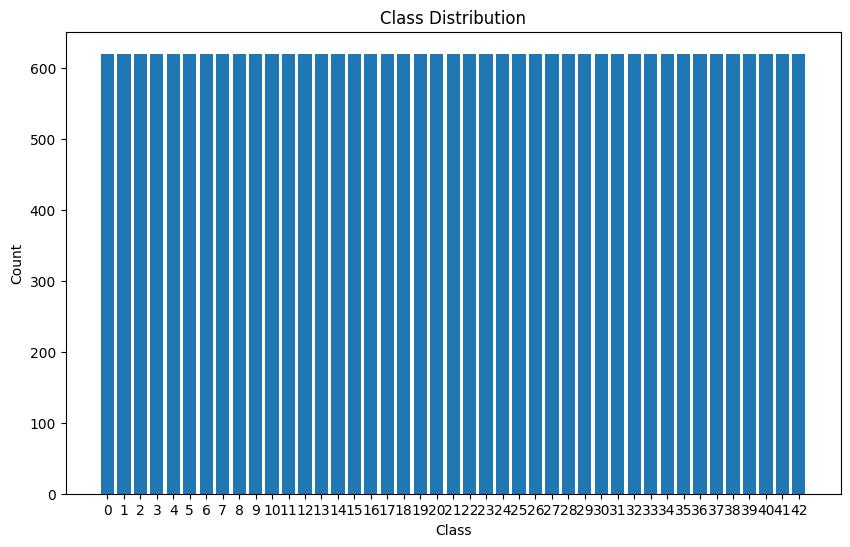

In [ ]:
# Count the occurrences of each class in the DataFrame
class_counts = df_classes['class'].value_counts()

# Sort the unique class IDs
unique_classes = np.sort(df_classes['class'].unique())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts[unique_classes])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(unique_classes)
plt.show()

This shows that the images were equally distributed among the classes as what has being prepared in the previous notebook.

Both images are first split into training and validation sets. They are grouped by their classes and stored in individual directories for every classes.

In [ ]:
train_dir = '/content/train_images'
valid_dir = '/content/valid_images'

# Create directories for training and validation images
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Split the data into training and validation sets
train_df, valid_df = train_test_split(df_classes, test_size=0.2, random_state=42, stratify=df_classes['class'])

# Copy images to directories based on classes for training set
for index, row in train_df.iterrows():
    src_path = os.path.join(extracted_dir, row['filename'])
    dst_path = os.path.join(train_dir, str(row['class']), row['filename'])
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

# Copy images to directories based on classes for validation set
for index, row in valid_df.iterrows():
    src_path = os.path.join(extracted_dir, row['filename'])
    dst_path = os.path.join(valid_dir, str(row['class']), row['filename'])
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

print("Data preparation for ML completed.")

Data preparation for ML completed.


<h1> 5.2 Machine Learning</h1>

<h2>5.2.1 Data pipeline</h2>

<code>flow_from_directory()</code> from Keras ImageDataGenerator is used to load the images with rescaling to 1/255. batch size and image size are pre-set to 32 and (160, 160), respectively. These number were based on the upscaling of images in image enhancement.

In [ ]:
# Define paths
train_dir = '/content/train_images'
valid_dir = '/content/valid_images'

# Define image dimensions and batch size
image_size = (160,160)
batch_size = 32

# Create data generators and rescale image for ML on training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Load images as grayscale
    shuffle=True  # Set shuffle to True for training data
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Load images as grayscale
    shuffle=False  # Set shuffle to False for validation data
)

# Get the number of classes from the training generator
num_classes = len(train_generator.class_indices)

Found 21328 images belonging to 43 classes.
Found 5332 images belonging to 43 classes.


Total <b>21328</b> images are loaded into the training data and <b>5332</b> images are loaded into the validation data.

Next, the test data is also obtained and prepared for machine learning.

In [ ]:
# Define the paths
test_zip_path = '/content/drive/MyDrive/final/test_data/test_image_enhanced_PIL_simple.zip'
test_extracted_dir = '/content/extracted_test_images'
test_dir = '/content/test_images'

# Create the directory for extracted test images if it doesn't exist
os.makedirs(test_extracted_dir, exist_ok=True)

# Open the ZIP file and extract its contents
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extracted_dir)

In [ ]:
# Move the test images to the test directory while renaming them with their true labels
for filename in os.listdir(test_extracted_dir):
    src_path = os.path.join(test_extracted_dir, filename)
    # Extract the true label from the filename (before the underscore)
    true_label = filename.split('_')[0]
    dst_path = os.path.join(test_dir, true_label, filename)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

Data generator is used for loading images into the model.

In [ ]:
# Create a data generator for the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Load images as grayscale
    shuffle=False  # Set shuffle to False for testing data
)

Found 12599 images belonging to 43 classes.


<h2>5.2.2 Training the CNN model</h2>

As there are many models training at the same time, the first image in the training data is inspected on size to confirm the shape of the nerual network.

In [ ]:
# Define the path to the image file
image_path = os.path.join('train_images', '0', '0_0.png')

# Open the image using PIL
image = Image.open(image_path)

# Get the size (dimensions) of the image
image_size = image.size

# Close the image file
image.close()

# Print the size of the image
print("Size of '0_0.png' in folder '0':", image_size)


Size of '0_0.png' in folder '0': (160, 160)


In [ ]:
# Retrieve the first batch from the training generator
images, labels = next(train_generator)

# Get the first image from the batch
first_image = images[0]

# Check the shape of the first image
print("Shape of the first image:", first_image.shape)


Shape of the first image: (160, 160, 1)


The size of image accurate reflects the simple enhanced data with all three channels.

The GPU avaliability is also double checked.

In [ ]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Specify GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


A function is defined to plot the training history and calculate the changes in accuracy and loss.

In [ ]:
def calculate_accuracy_increase_rate(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    train_rate = np.mean(np.diff(train_accuracy))
    val_rate = np.mean(np.diff(val_accuracy))

    return train_rate, val_rate

In [ ]:
def plot_training_history(history):
    # Access the training history
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting the training and validation accuracy
    ax1.plot(training_accuracy)
    ax1.plot(validation_accuracy)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plotting the training and validation loss
    ax2.plot(training_loss)
    ax2.plot(validation_loss)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()

Then, true labels are extracted from the test generator for testing later.

In [ ]:
# Get true labels from the test generator
true_labels = test_generator.classes

# Get unique true labels
class_names = [str(label) for label in range(43)]

The model development will start from developing a simple model that serves as a baseline in this development cycle. It is different from the basline of the whole project as this is trained on enhanced and augmented data.

<h2> Model 1: Simple CNN baseline</h2>


Training the CNN model to upto 30 epochs, early stopping is used to prevent overfitting. However, no regularization is applied.

In [ ]:
# Define the CNN layers
input_layer = Input(shape=(160, 160, 1))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
model_CNN = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_CNN.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

A simple summary of the model is displayed:

In [ ]:
model_CNN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 158, 158, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 79, 79, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 36, 128)       7385

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
num_epochs = 30
history_simpleCNN = model_CNN.fit(train_generator,
                                  epochs=num_epochs,
                                  validation_data=valid_generator,
                                  callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/30
667/667 [==============================] - 68s 78ms/step - loss: 1.7935 - accuracy: 0.4992 - val_loss: 0.5905 - val_accuracy: 0.8323
Epoch 2/30
667/667 [==============================] - 49s 73ms/step - loss: 0.6986 - accuracy: 0.7846 - val_loss: 0.3282 - val_accuracy: 0.9079
Epoch 3/30
667/667 [==============================] - 56s 85ms/step - loss: 0.4682 - accuracy: 0.8516 - val_loss: 0.2973 - val_accuracy: 0.9160
Epoch 4/30
667/667 [==============================] - 72s 108ms/step - loss: 0.3451 - accuracy: 0.8889 - val_loss: 0.2266 - val_accuracy: 0.9319
Epoch 5/30
667/667 [==============================] - 58s 86ms/step - loss: 0.2754 - accuracy: 0.9116 - val_loss: 0.2321 - val_accuracy: 0.9278
Epoch 6/30
667/667 [==============================] - 44s 65ms/step - loss: 0.2370 - accuracy: 0.9232 - val_loss: 0.1742 - val_accuracy: 0.9479
Epoch 7/30
667/667 [==============================] - 43s 65ms/step - loss: 0.1916 - accuracy: 0.9373 - val_loss: 0.1591 - val_accuracy

The training stopped at <b>epoch 17</b> as the model started overfitting (shown by the validation loss). The training accuracy and validation accuracy graph are shown below.

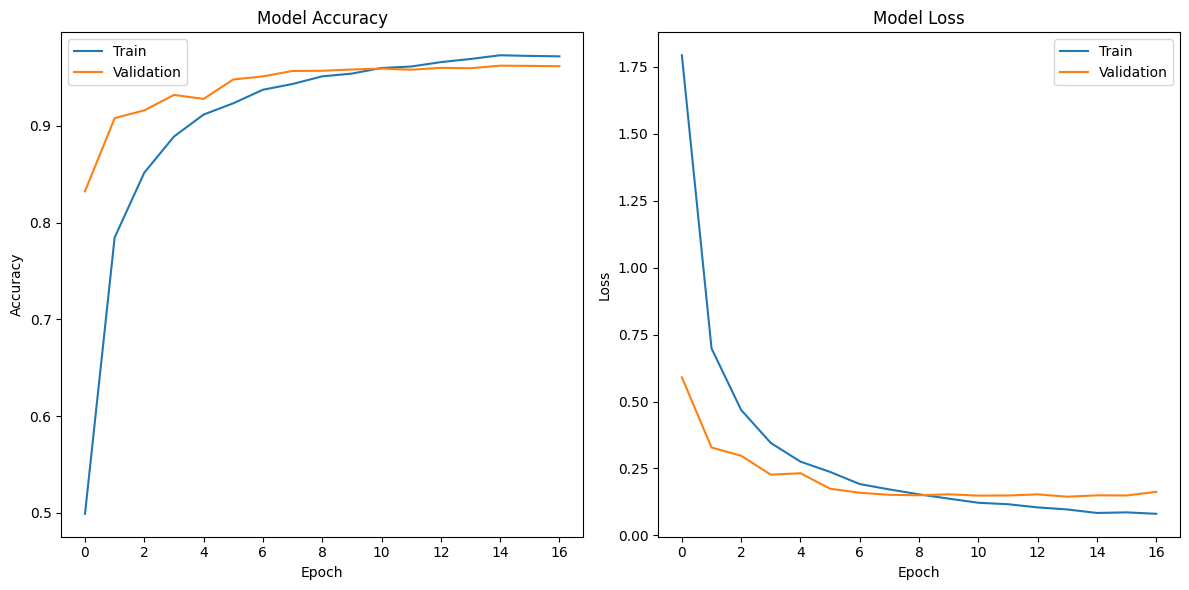

In [ ]:
plot_training_history(history_simpleCNN)

This model has a higher training accuracy than validation accuracy. And the validaton accuracy is continuesly increasing, indicating no signs of overfitting.

In [ ]:
# Increasing rate
train_rate_SCNN, val_rate_SCNN = calculate_accuracy_increase_rate(history_simpleCNN)
print("Training Accuracy Increase Rate:", train_rate_SCNN)
print("Validation Accuracy Increase Rate:", val_rate_SCNN)

Training Accuracy Increase Rate: 0.029538637027144432
Validation Accuracy Increase Rate: 0.008076239377260208


The rate of increase for accuracy is calculated above

Then, the model is evaluated on the test data

In [ ]:
# Test the model with the test data
test_loss_SCNN, test_accuracy_SCNN = model_CNN.evaluate(test_generator)

print(f"Test Loss: {test_loss_SCNN:.4f}")
print(f"Test Accuracy: {test_accuracy_SCNN:.4f}")

394/394 [==============================] - 24s 60ms/step - loss: 0.6013 - accuracy: 0.8718
Test Loss: 0.6013
Test Accuracy: 0.8718


In [ ]:
# Make predictions on the test data
test_pred_SCNN = model_CNN.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
pred_labels_SCNN = np.argmax(test_pred_SCNN, axis=1)

# Calculate the precision score
precision_SCNN = precision_score(true_labels, pred_labels_SCNN, average='weighted')

print(f"Precision Score: {precision_SCNN:.4f}")

394/394 [==============================] - 24s 60ms/step
Precision Score: 0.8766


In [ ]:
# Generate a classification report
class_rep_SCNN = classification_report(true_labels, pred_labels_SCNN, target_names=class_names)

print("Classification Report:\n", class_rep_SCNN)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       293
           1       0.96      0.94      0.95       293
           2       0.93      0.98      0.95       293
           3       0.83      0.95      0.88       293
           4       0.98      0.98      0.98       293
           5       0.99      1.00      0.99       293
           6       0.98      0.96      0.97       293
           7       0.96      0.98      0.97       293
           8       0.89      0.98      0.93       293
           9       0.98      0.93      0.96       293
          10       0.96      0.86      0.91       293
          11       0.62      0.83      0.71       293
          12       0.95      0.96      0.95       293
          13       0.64      0.76      0.70       293
          14       0.78      0.86      0.82       293
          15       0.90      0.92      0.91       293
          16       0.71      0.71      0.71       293
   

Generally, the model is performing well with a test precision of 87.66% and test accuracy of 87.18%. For acciracy across all classes, the worst performing one is class 13 with 64% precision and 70% F1 score. It is also noticed that some classes have perfect scores on precision.

<h2> Model 2: More complex CNN with regularization</h2>



More complexity is added to the CNN model with regularization added:

*   Added more convolutional layers with increasing filters to capture more complex features

*   Added batch normalization layers after each convolutional and dense layer to help stabilize training. (Recommended in chapter 7.3.1 Advanced architechtures in Deep Learning with Python, Francois Chollet)

*   Added an additional dense layer with dropout and batch normalization.

In [ ]:
# Define the CNN layers
input_layer = Input(shape=(160, 160, 1))
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
model_complex = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate
model_complex.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


A simple summary of the model is displayed:

In [ ]:
model_complex.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 158, 158, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 158, 158, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 79, 79, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 77, 77, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 77, 77, 128)       512 

The model is trained with the early stopping callback monitering the validation loss:

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with data augmentation and early stopping
num_epochs = 50
history_complex_model = model_complex.fit(train_generator,
                                          epochs=num_epochs,
                                          validation_data=valid_generator,
                                          callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/50
667/667 [==============================] - 70s 98ms/step - loss: 12.5522 - accuracy: 0.5224 - val_loss: 8.9028 - val_accuracy: 0.7689
Epoch 2/50
667/667 [==============================] - 61s 92ms/step - loss: 7.2677 - accuracy: 0.7427 - val_loss: 5.4524 - val_accuracy: 0.8547
Epoch 3/50
667/667 [==============================] - 61s 91ms/step - loss: 4.8748 - accuracy: 0.7909 - val_loss: 3.9272 - val_accuracy: 0.8796
Epoch 4/50
667/667 [==============================] - 60s 90ms/step - loss: 3.6706 - accuracy: 0.8328 - val_loss: 3.0446 - val_accuracy: 0.8978
Epoch 5/50
667/667 [==============================] - 60s 90ms/step - loss: 3.0420 - accuracy: 0.8492 - val_loss: 2.7376 - val_accuracy: 0.9130
Epoch 6/50
667/667 [==============================] - 60s 90ms/step - loss: 2.6816 - accuracy: 0.8718 - val_loss: 2.3554 - val_accuracy: 0.9387
Epoch 7/50
667/667 [==============================] - 61s 91ms/step - loss: 2.3699 - accuracy: 0.9033 - val_loss: 2.3144 - val_accuracy

The training stopped at <b>epoch 29</b> as the model started overfitting (shown by the validation loss). This happend <b> 12 epoch</b> after the previous model. Potentially, the model uncovered more hidden features. The training accuracy and validation accuracy graph are shown below.

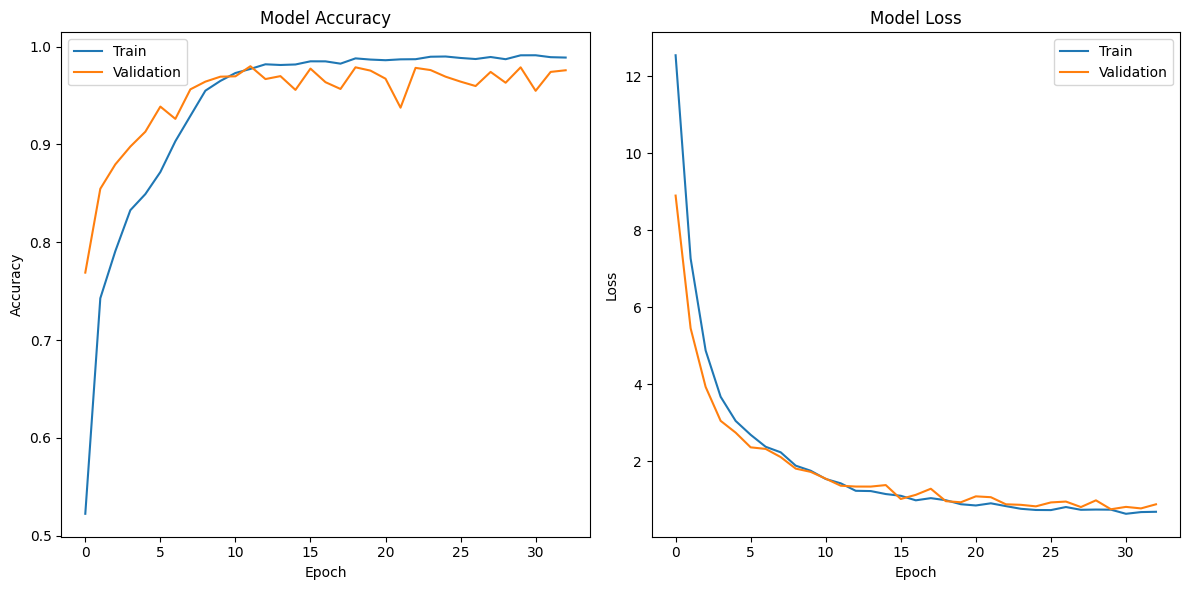

In [ ]:
plot_training_history(history_complex_model)

This model has a higher training accuracy than validation accuracy from about **epoch 10**. And the validaton accuracy is **continuesly increasing**, with some fluctations. However, it is still** no indication of overfitting**.

In [ ]:
# Increasing rate
train_rate_complex, val_rate_complex = calculate_accuracy_increase_rate(history_complex_model)
print("Training Accuracy Increase Rate:", train_rate_complex)
print("Validation Accuracy Increase Rate:", val_rate_complex)

Training Accuracy Increase Rate: 0.01457444578409195
Validation Accuracy Increase Rate: 0.006464507430791855


The rate of increase for accuracy is calculated above. It is increasing at a slower rate than the simple CNN model.

Then, the model is evaluated on the test data

In [ ]:
# Test the model with the test data
test_loss_complex, test_accuracy_complex = model_complex.evaluate(test_generator)

print(f"Test Loss: {test_loss_complex:.4f}")
print(f"Test Accuracy: {test_accuracy_complex:.4f}") # 89

394/394 [==============================] - 27s 69ms/step - loss: 0.9575 - accuracy: 0.9236
Test Loss: 0.9575
Test Accuracy: 0.9236


In [ ]:
# Make predictions on the test data
test_pred_complex = model_complex.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_labels_complex = np.argmax(test_pred_complex, axis=1)

# Calculate the precision score
precision_complex = precision_score(true_labels, predicted_labels_complex, average='weighted')

print(f"Precision Score: {precision_complex:.4f}")

394/394 [==============================] - 27s 69ms/step
Precision Score: 0.9270


In [ ]:
# Generate a classification report
class_rep_complex = classification_report(true_labels, predicted_labels_complex, target_names=class_names)

print("Classification Report:\n", class_rep_complex)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       293
           1       0.92      0.98      0.95       293
           2       0.96      0.98      0.97       293
           3       0.91      0.97      0.94       293
           4       1.00      0.93      0.96       293
           5       0.99      1.00      0.99       293
           6       0.95      0.97      0.96       293
           7       0.94      0.98      0.96       293
           8       0.87      0.97      0.92       293
           9       1.00      0.98      0.99       293
          10       0.93      0.95      0.94       293
          11       0.94      0.96      0.95       293
          12       0.93      0.97      0.95       293
          13       0.82      0.96      0.89       293
          14       0.92      0.92      0.92       293
          15       0.85      0.90      0.87       293
          16       0.85      0.92      0.89       293
   

Generally, the model is performing well with a test precision of 92.7% and test accuracy of 92.3%. For accuracy across all classes, the worst performing one is class 31 with 79% precision and 93% F1 score. It is also noticed that a few classes have perfect scores on precision.

This model improved the performance of the simple CNN model especially on the accuracy across all classes on test data.

<h2> Model 3: Even more complex CNN with Learning rate adjustment</h2>

An attempt has been made to add more layers to the model with a **lower learning rate**. It could potentially allow a **more complexed model** with less likelihood of overfitting, at a cost of **increased training time**.

In [ ]:
# Define the CNN layers
input_layer = Input(shape=(160, 160, 1))
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)
# Create the model
model_more_complex = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate
model_more_complex.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_more_complex.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 158, 158, 64)      640       
                                                                 
 batch_normalization_6 (Bat  (None, 158, 158, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 79, 79, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 77, 77, 128)       73856     
                                                                 
 batch_normalization_7 (Bat  (None, 77, 77, 128)       512 

In [ ]:
# Compile the model with a lower learning rate
model_more_complex.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
num_epochs = 50
history_more_complex_model = model_more_complex.fit(train_generator,
                                                    epochs=num_epochs,
                                                    validation_data=valid_generator,
                                                    callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/50
667/667 [==============================] - 67s 91ms/step - loss: 11.3119 - accuracy: 0.5483 - val_loss: 7.0044 - val_accuracy: 0.7832
Epoch 2/50
667/667 [==============================] - 61s 92ms/step - loss: 6.0178 - accuracy: 0.7627 - val_loss: 4.5130 - val_accuracy: 0.8760
Epoch 3/50
667/667 [==============================] - 59s 89ms/step - loss: 4.2522 - accuracy: 0.8266 - val_loss: 3.4575 - val_accuracy: 0.8961
Epoch 4/50
667/667 [==============================] - 62s 93ms/step - loss: 3.3737 - accuracy: 0.8662 - val_loss: 2.9241 - val_accuracy: 0.9100
Epoch 5/50
667/667 [==============================] - 60s 90ms/step - loss: 2.8169 - accuracy: 0.8917 - val_loss: 2.4710 - val_accuracy: 0.9381
Epoch 6/50
667/667 [==============================] - 60s 90ms/step - loss: 2.4376 - accuracy: 0.9096 - val_loss: 2.2253 - val_accuracy: 0.9381
Epoch 7/50
667/667 [==============================] - 61s 91ms/step - loss: 2.0572 - accuracy: 0.9256 - val_loss: 1.8232 - val_accuracy

The training stopped at **epoch 38** as the model started overfitting (shown by the validation loss). This happend **9 epoch after** the previous model. The training accuracy and validation accuracy graph are shown below. It was noted that the **training accuracy** and the **validation accuracy** are both **very high**.

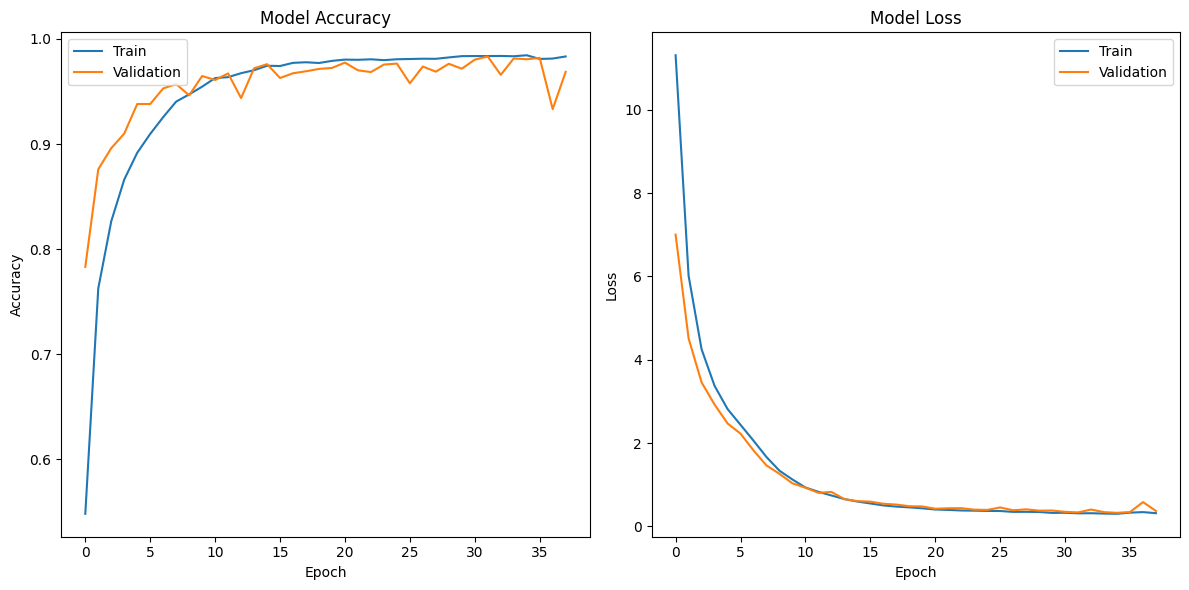

In [ ]:
plot_training_history(history_more_complex_model)

This model has a higher training accuracy than validation accuracy. And the validaton accuracy is continuesly increasing, with significant fluctuations nearing the end. However, it is still no indications of overfitting.

In [ ]:
# Increasing rate
train_rate_mComplex, val_rate_mComplex = calculate_accuracy_increase_rate(history_more_complex_model)
print("Training Accuracy Increase Rate:", train_rate_mComplex)
print("Validation Accuracy Increase Rate:", val_rate_mComplex)

Training Accuracy Increase Rate: 0.011758428973120611
Validation Accuracy Increase Rate: 0.005013077645688443


The rate of increase for accuracy is calculated above. It is training at a much slower rate than the simple CNN model.

Then, the model is evaluated on the test data

In [ ]:
# Test the model with the test data
test_loss_mComplex, test_accuracy_mComplex = model_more_complex.evaluate(test_generator)

print(f"Test Loss: {test_loss_mComplex:.4f}")
print(f"Test Accuracy: {test_accuracy_mComplex:.4f}")

394/394 [==============================] - 25s 64ms/step - loss: 0.5811 - accuracy: 0.9090
Test Loss: 0.5811
Test Accuracy: 0.9090


In [ ]:
# Make predictions on the test data
test_pred_mComplex = model_more_complex.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_labels_mComplex = np.argmax(test_pred_mComplex, axis=1)

# Calculate the precision score
precision_mComplex = precision_score(true_labels, predicted_labels_mComplex, average='weighted')

print(f"Precision Score: {precision_mComplex:.4f}") # 85 87

394/394 [==============================] - 24s 62ms/step
Precision Score: 0.9166


In [ ]:
# Generate a classification report
class_rep_mComplex = classification_report(true_labels, predicted_labels_mComplex, target_names=class_names)

print("Classification Report:\n", class_rep_mComplex)

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       293
           1       0.90      0.97      0.93       293
           2       1.00      0.99      0.99       293
           3       0.96      0.98      0.97       293
           4       0.99      0.92      0.96       293
           5       1.00      0.99      0.99       293
           6       1.00      0.93      0.96       293
           7       0.93      0.98      0.95       293
           8       0.85      0.98      0.91       293
           9       1.00      0.95      0.98       293
          10       0.91      0.88      0.89       293
          11       0.90      0.87      0.89       293
          12       0.97      0.98      0.98       293
          13       0.84      0.92      0.88       293
          14       0.89      0.93      0.91       293
          15       0.96      0.86      0.91       293
          16       0.90      0.89      0.90       293
   

Although the model is performing much better in training data, the result on test data **very similar** to the previous model. **Althernative model is recommended** as this is learning at a slower rate with more computational power needed.

<h2> Model 4: Even more complex CNN with regularization and more layers</h2>


As the previous model not performing well, an attempt has been made to add more layers to the model so that it could potentially allow a **more complexed model** with less likelihood of overfitting, at a cost of **increased training time**.

In [ ]:
# Define a more complex CNN architecture
input_layer = Input(shape=(160, 160, 1))
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)

# Add another dense layer with dropout
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
model_modified = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate
model_modified.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


The above model is revised from all previous models. It added more omore set of dense layers and dropout layers with regularization. It also had a lower learning rate.

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
num_epochs = 50
history_modified_model = model_modified.fit(train_generator,
                                            epochs=num_epochs,
                                            validation_data=valid_generator,
                                            callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/50
667/667 [==============================] - 68s 95ms/step - loss: 13.8426 - accuracy: 0.2964 - val_loss: 7.9290 - val_accuracy: 0.6504
Epoch 2/50
667/667 [==============================] - 62s 92ms/step - loss: 6.9111 - accuracy: 0.5617 - val_loss: 4.8876 - val_accuracy: 0.8110
Epoch 3/50
667/667 [==============================] - 60s 90ms/step - loss: 4.7278 - accuracy: 0.6926 - val_loss: 3.5268 - val_accuracy: 0.8788
Epoch 4/50
667/667 [==============================] - 61s 92ms/step - loss: 3.4829 - accuracy: 0.7846 - val_loss: 2.7011 - val_accuracy: 0.9164
Epoch 5/50
667/667 [==============================] - 60s 90ms/step - loss: 2.6856 - accuracy: 0.8434 - val_loss: 2.1533 - val_accuracy: 0.9360
Epoch 6/50
667/667 [==============================] - 61s 92ms/step - loss: 2.0696 - accuracy: 0.8924 - val_loss: 1.6878 - val_accuracy: 0.9527
Epoch 7/50
667/667 [==============================] - 62s 93ms/step - loss: 1.6079 - accuracy: 0.9225 - val_loss: 1.4144 - val_accuracy

The training stopped at **epoch 26** as the model started overfitting (shown by the validation loss). This happend 12 epoch before the previous model. The training accuracy and validation accuracy graph are shown below. It was noted that the **training accuracy** and the **validation accuracy** are both **still very high**.

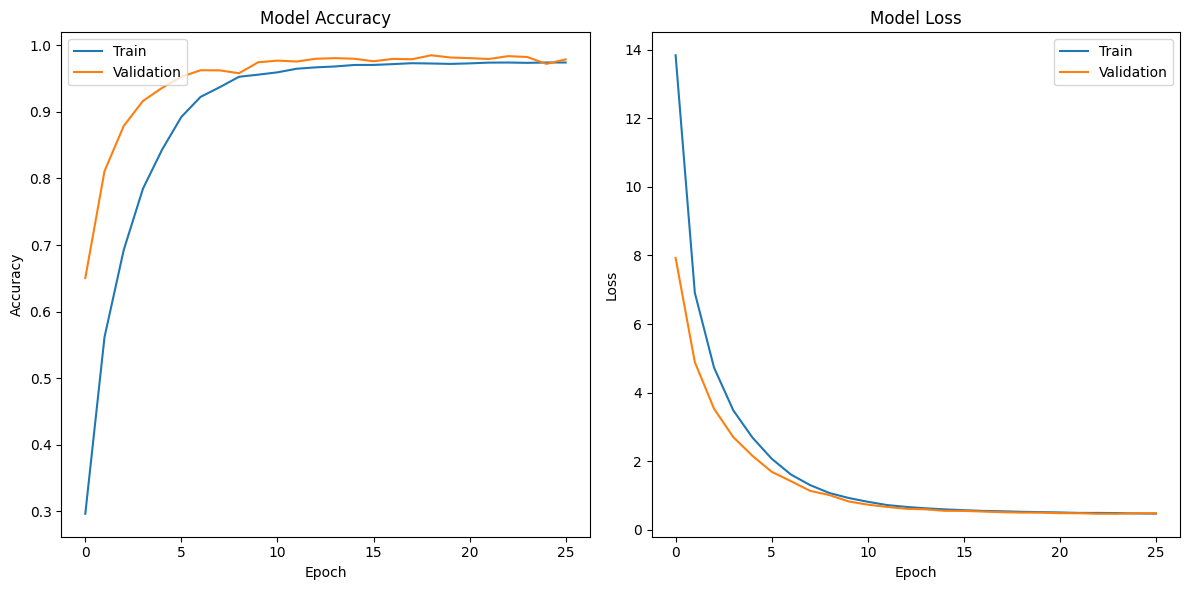

In [ ]:
plot_training_history(history_modified_model)

This model has a similar training accuracy than validation accuracy. UnLike the previous model, validation accuracy did **not experienced significant fluctuations**. The model is thus much more **stable**. Moreover, it is still no indications of overfitting.

In [ ]:
# Test the model with the test data
test_loss_mComplex, test_accuracy_mComplex = model_modified.evaluate(test_generator)

print(f"Test Loss: {test_loss_mComplex:.4f}")
print(f"Test Accuracy: {test_accuracy_mComplex:.4f}")

394/394 [==============================] - 27s 68ms/step - loss: 0.6445 - accuracy: 0.9296
Test Loss: 0.6445
Test Accuracy: 0.9296


In [ ]:
# Make predictions on the test data
test_pred_modified = model_modified.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_labels_modified = np.argmax(test_pred_modified, axis=1)

# Calculate the precision score
precision_modified = precision_score(true_labels, predicted_labels_modified, average='weighted')

print(f"Precision Score: {precision_modified:.4f}") # 85 87

394/394 [==============================] - 26s 65ms/step
Precision Score: 0.9337


After this adjustment, the new model did **not perform better** than the previous model. Thus, the exploration of model structure is concluded.

The project will more on to saving this model and training of other models.

 <h1> 5.3 Saving the model</h1>

The raw predictions, training history, and model are saved below. They were all saved to google drive for reusing and analysis in the future.



In [ ]:
# Define the file path where you want to save the raw predictions
save_path = "best_test_predictions_CNN.npy"

# Save the raw predictions to the specified file
np.save(save_path, test_pred_modified)

print(f"Raw predictions saved to '{save_path}'.")

Raw predictions saved to 'best_test_predictions_CNN.npy'.


In [ ]:
model_modified.save("final_CNN_model.keras")

In [ ]:
def save_training_history(history, filename):
    # Create a DataFrame from the training history
    history_df = pd.DataFrame(history.history)

    # Save the DataFrame to a CSV file
    history_df.to_csv(filename, index=False)

    # Print the first few rows of the history DataFrame
    print(history_df.head())

In [ ]:
save_training_history(history_simpleCNN, 'training_history_simpleCNN.csv')
save_training_history(history_modified_model, 'training_history_complexCNN.csv')

       loss  accuracy  val_loss  val_accuracy
0  1.793514  0.499156  0.590471      0.832333
1  0.698569  0.784649  0.328200      0.907914
2  0.468224  0.851604  0.297311      0.915979
3  0.345081  0.888878  0.226612      0.931920
4  0.275400  0.911619  0.232147      0.927794
        loss  accuracy  val_loss  val_accuracy
0  13.842560  0.296418  7.928982      0.650413
1   6.911101  0.561750  4.887598      0.810953
2   4.727787  0.692564  3.526845      0.878845
3   3.482876  0.784555  2.701056      0.916354
4   2.685626  0.843445  2.153270      0.936047


In [ ]:
import shutil
import os

# Define the destination directory in Google Drive
dest_dir = 'drive/MyDrive/final/training_models/CNN/'

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Define the source paths
src_paths = [
    'final_CNN_model.h5',
    'final_CNN_model.keras',
    'training_history_simpleCNN.csv',
    'training_history_complexCNN.csv',
    'best_test_predictions_CNN.npy'
]

# Copy files to Google Drive
for src_path in src_paths:
    shutil.copy(src_path, dest_dir)

print("Files copied to Google Drive successfully.")

Files copied to Google Drive successfully.
